## Parsing unity VR log file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep, isfile, exists
from os import mkdir, makedirs
import json

In [2]:
from unityvr.preproc import logproc
from unityvr.viz import viz

In [3]:
dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-14_17-20-18.json"#"Log_2020-8-31_19-15-6_4.json"#


dat = logproc.openUnityLog(dirName, fileName)

for i in range(3):
    print(dat[i])
    #print(dat[i]['frame'])
    #print(json.dumps(dat[i]['data'], sort_keys=True, indent=4))

{'timeSecs': 0.0, 'frame': 0.0, 'headerNotes': '-experiment:test writing photodiode signal to log -genotype:none -flyid:none -sex:none  '}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera3/FlyCamera3Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 38.428314208984375, 'y': 30.339401245117188, 'z': -52.89203643798828}, 'worldRotationDegs': {'x': 0.0, 'y': 324.0, 'z': 0.0}, 'worldScale': {'x': 95.00000762939453, 'y': 182.0, 'z': 1.0}}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera1/FlyCamera1Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 0.0, 'y': 30.339401245117188, 'z': 65.37814331054688}, 'worldRotationDegs': {'x': 0.0, 'y': 180.0, 'z': 0.0}, 'worldScale': {'x': 95.0, 'y': 182.0, 'z': 1.0}}


### Construct data object from log file
#### Extract header info

In [4]:
print(dat[0]['headerNotes'])
logproc.parseHeader(dat[0]['headerNotes'])

-experiment:test writing photodiode signal to log -genotype:none -flyid:none -sex:none  


('testExp', 'test writing photodiode signal to log', 'none', 'none', 'none')

#### Pull out object positions as pandas dataframe

In [5]:
objDf = logproc.objDfFromLog(dat)
objDf.head()

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,38.428314,-52.892036,30.339401,0.0,0.0,324.0,95.000008,1.0,182.0
1,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,0.000000,65.378143,30.339401,0.0,0.0,180.0,95.000000,1.0,182.0
2,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,62.178310,20.202957,30.339401,0.0,0.0,252.0,95.000008,1.0,182.0
3,LMlocal1,CapsuleCollider,0.000000,-200.000000,27.000000,0.0,0.0,0.0,10.000000,10.0,30.0
4,LMlocal2,CapsuleCollider,300.000000,200.000000,27.000000,0.0,0.0,0.0,10.000000,10.0,30.0


#### Pull out fly position as pandas dataframe
Position in VR

In [6]:
posDf, ftDf = logproc.timeseriesDfFromLog(dat)

In [7]:
print(len(posDf))
posDf.head()

4515


,frame,time,x,y,angle,dx,dxattempt,dy,dyattempt
0,1.0,0.000000,-0.078331,-0.060475,359.989075,-0.078331,-0.078331,-0.060475,-0.060475
1,2.0,0.020000,-0.133139,-0.065043,359.990326,-0.054809,-0.054809,-0.004557,-0.004557
2,3.0,0.029311,-0.133139,-0.065043,359.990326,0.000000,0.000000,0.000000,0.000000
3,4.0,0.033206,-0.133139,-0.065043,359.990326,0.000000,0.000000,0.000000,0.000000
4,5.0,0.037125,-0.133139,-0.065043,359.990326,0.000000,0.000000,0.000000,0.000000


Position based on Fictrac tracking

In [8]:
print(len(ftDf))
ftDf.head()

4312


,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,0.0,0.0,-0.001324,-0.000897,0.000514
1,1.0,6.0,7596069.0,-0.000763,-0.001069,-0.000527
2,1.0,14.0,15193034.0,-0.000814,-0.001043,-0.000423
3,1.0,21.0,22790243.0,-0.000776,-0.001124,0.000573
4,1.0,29.0,30387452.0,0.002431,0.002130,-0.000476


Fictrac updates come in at a higher rate than the VR frame rate. Fictrac can also only run for a subset of the VR run time and therefore the number of frames in fictrac and vr dataframes may not match.

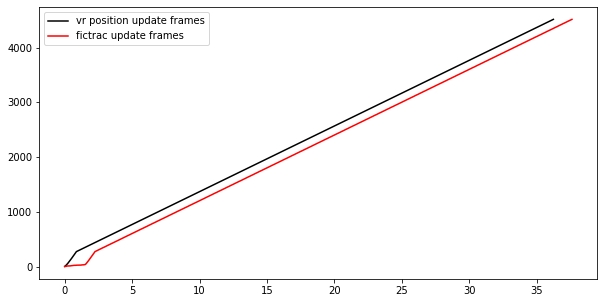

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(posDf.time, posDf.frame, 'k')
ax.plot(ftDf.ficTracTReadMs/1000, ftDf.frame, 'r')
ax.legend(['vr position update frames','fictrac update frames'])

#### Generate data object

In [4]:
dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-14_17-20-18.json"#"Log_2020-8-31_19-15-6_4.json"#

uvrTest = logproc.constructUnityVRexperiment(dirName,fileName)
uvrTest.printMetadata()

Metadata:

expid  :  testExp
experiment  :  test writing photodiode signal to log
genotype  :  none
sex  :  none
flyid  :  none
date  :  2021-01-14
time  :  17-20-18


In [5]:
uvrTest.saveData(dirName)

In [6]:
frameftDf = uvrTest.downsampleftDf()
frameftDf.head()

,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,267.0,2.734885e+08,-0.002734,-0.002111,-0.000381
1,2.0,345.0,3.494650e+08,-0.001913,-0.000159,0.000043
2,9.0,2411.0,2.415884e+09,-0.003989,-0.007542,0.006979
3,10.0,4656.0,4.672240e+09,0.002436,-0.000269,0.000909
4,11.0,379.0,3.798571e+08,-0.000656,-0.000560,0.000439


### ToDo: Write method to construct data class from saved files

#### Extract NIDAQ-recorded photodiode trace

In [221]:
from scipy.signal import filtfilt,  butter

def pdDfFromLog(dat):
    pdDf = pd.DataFrame(columns=['frame','timeSecs','pdSig'])

    nlines = sum(1 for line in dat)

    for l in range(nlines):
        if 'data' in dat[l].keys(): 
            line = dat[l]['data']
        else:
            line = dat[l]
        if('tracePD' in line.keys()):
            framedat = {'frame': line['frame'],
                        'timeSecs':line['timeSecs'],
                        'pdSig': line['tracePD']}
            pdDf = pdDf.append(framedat, ignore_index = True)
            
    #pdDf["pdFilt"] = savgol_filter(pdDf.pdSig, 5, 2)
    # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
    b, a = butter(3, 0.2)
    pdDf["pdFilt"]  = filtfilt(b, a, pdDf.pdSig)
    pdDf["pdThresh"]  = 1*(np.asarray(pdDf.pdFilt>np.median(pdDf.pdFilt.values)))
    pdDf['count'] = 1
    return pdDf

In [259]:
pdDf = pdDfFromLog(dat)
pdDf.head()

,frame,timeSecs,pdSig,pdFilt,pdThresh
0,2.0,0.020000,0.078625,0.078985,0
1,2.0,0.020000,0.079274,0.080223,0
2,2.0,0.020000,0.079274,0.081069,0
3,2.0,0.020000,0.079923,0.081300,0
4,2.0,0.020000,0.079923,0.080795,0
...,...,...,...,...,...
35153,4384.0,35.136528,0.205432,0.197726,0
35154,4384.0,35.136528,0.206405,0.211686,0
35155,4384.0,35.136528,0.205756,0.215792,0
35156,4384.0,35.136528,0.206081,0.212671,0


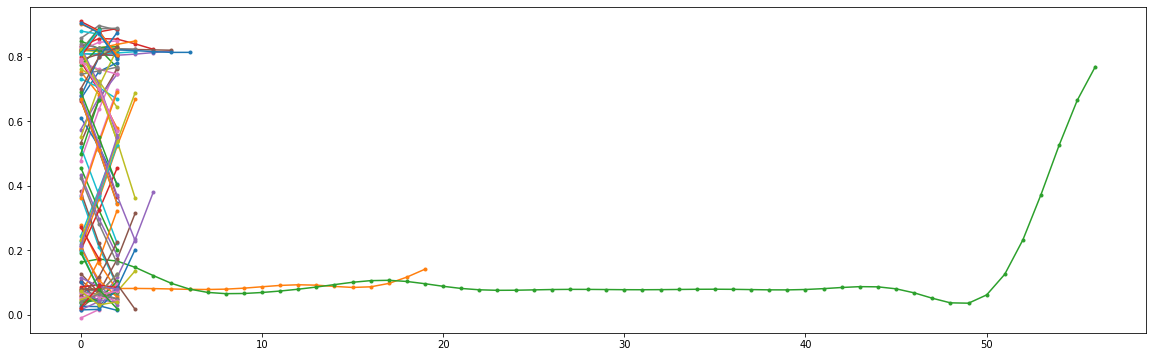

In [284]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
for f in range(1,100):
    sig = pdDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdFilt)), sig.pdFilt, '.-')

In [237]:
perframe = pdDf.groupby("frame").sum().reset_index()
perframe

,frame,timeSecs,pdSig,pdFilt,pdThresh,dframe,count
0,2.0,0.400000,1.671098,1.773761,0,0.0,20
1,3.0,2.936509,7.286311,7.057214,4,57.0,57
2,4.0,0.290190,4.033550,4.204158,5,0.0,5
3,5.0,0.376481,4.908366,4.856204,6,6.0,6
4,6.0,0.404846,4.922312,4.927751,6,0.0,6
...,...,...,...,...,...,...,...
4378,4380.0,245.721699,1.436403,1.457799,0,0.0,7
4379,4381.0,316.002811,1.013780,0.978711,0,9.0,9
4380,4382.0,280.958038,1.374600,1.402147,0,0.0,8
4381,4383.0,281.024719,0.826834,0.773462,0,8.0,8


In [238]:
pertime = pdDf.groupby("timeSecs").sum().reset_index()
pertime

,timeSecs,frame,pdSig,pdFilt,pdThresh,dframe,count
0,0.020000,40.0,1.671098,1.773761,0,0.0,20
1,0.051518,171.0,7.286311,7.057214,4,57.0,57
2,0.058038,20.0,4.033550,4.204158,5,0.0,5
3,0.062747,30.0,4.908366,4.856204,6,6.0,6
4,0.067474,36.0,4.922312,4.927751,6,0.0,6
...,...,...,...,...,...,...,...
4378,35.103100,30660.0,1.436403,1.457799,0,0.0,7
4379,35.111423,39429.0,1.013780,0.978711,0,9.0,9
4380,35.119755,35056.0,1.374600,1.402147,0,0.0,8
4381,35.128090,35064.0,0.826834,0.773462,0,8.0,8


(2.5, 6.666666666666667)

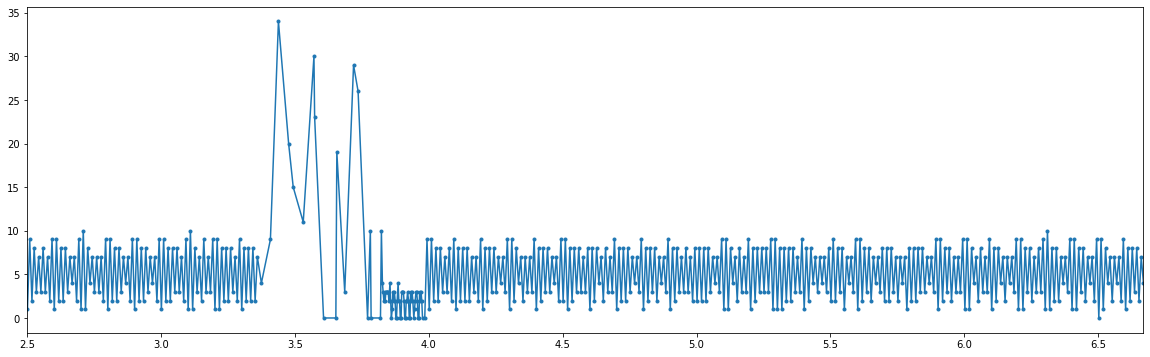

In [257]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pertime.timeSecs, pertime.pdThresh, '.-')
ax.set_xlim(300/120., 800/120.)

(300.0, 800.0)

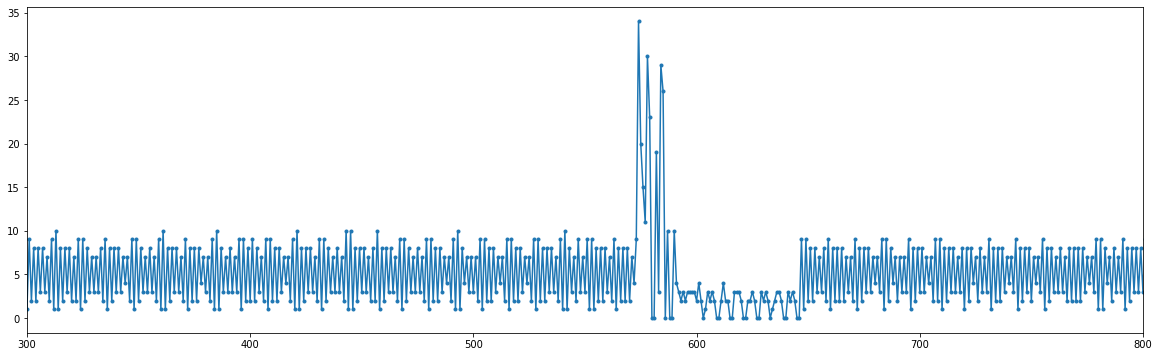

In [258]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(perframe.frame, perframe.pdThresh, '.-')
ax.set_xlim(300,800)

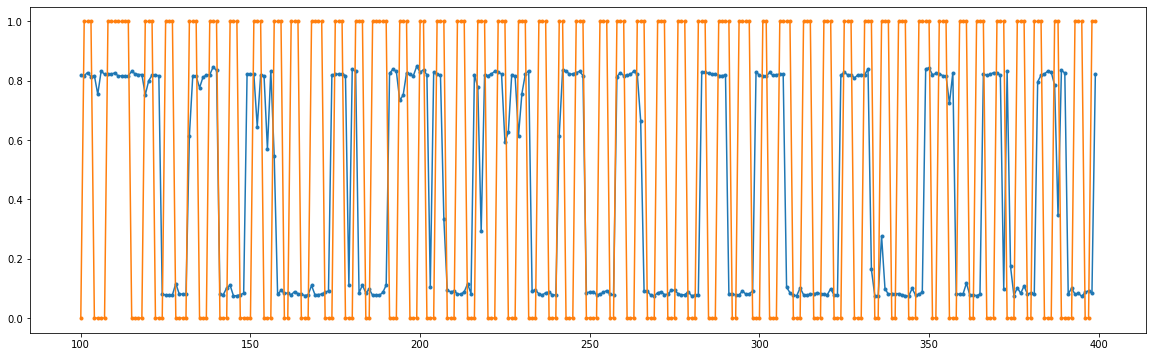

In [224]:
pdDf["dframe"] = pdDf.frame%2.

fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pdDf.pdSig[100:400], '.-')
#ax.plot(pdDf.pdFilt[100:400], '.-')
#ax.plot(pdDf.pdThresh[100:400], '.-')
ax.plot(pdDf.dframe[100:400], '.-')

In [208]:
rise = np.where(np.diff(np.asarray(pdDf.pdThresh.values))>0.1)[0]
len(rise)

1657

In [219]:
1000/8

125.0

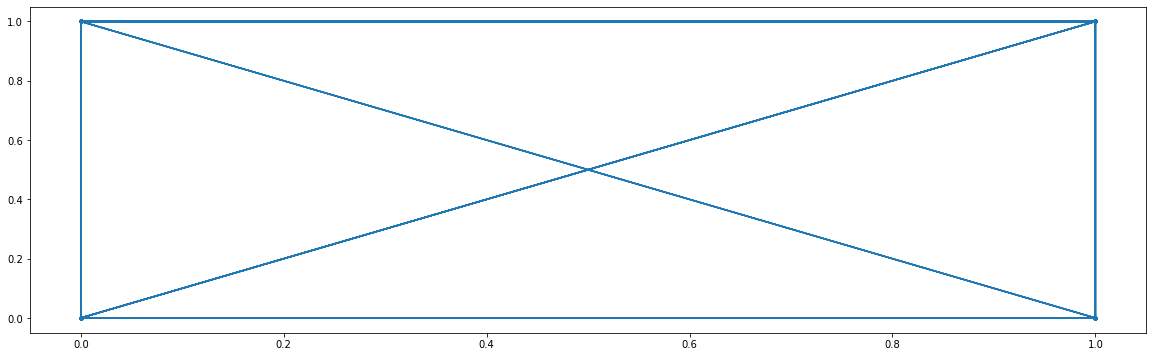

In [211]:


fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pdDf.dframe[100:400], pdDf.pdThresh[100:400], '.-')

### Vizualize

#### Frame rate

Unity log framerate: 124.71996658445137
Fictrac log framerate: 120.84046266511533
Down sampled fictrac log framerate: 216.79983961966934


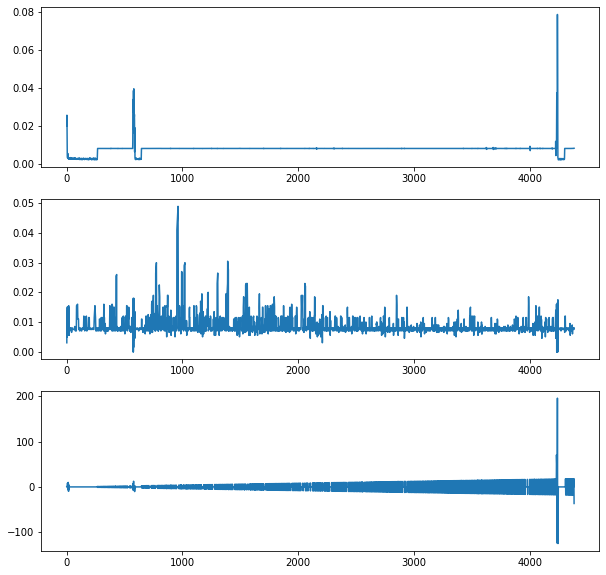

In [141]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))
axs[2].plot(uvrTest.downsampleftDf().frame,np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000.))

print('Unity log framerate: {}'.format(1/np.gradient(uvrTest.posDf.time).mean()))
print('Fictrac log framerate: {}'.format(1/np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
print('Down sampled fictrac log framerate: {}'.format(1/np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000).mean()))

**Compare to fictrac data log**

In [97]:
ftlog = 'fictrac-20210113_191354.dat'
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [108]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,14257021460976,0,0,6.923518e+07
1,1,0.004147,-0.003180,0.010677,4269.942690,0.003773,0.011271,0.000188,0.004147,-0.003180,...,-0.003774,6.282997,5.960194,0.011886,0.011271,-0.003773,14257029057982,1,7597006,6.923519e+07
2,2,-0.003169,0.002485,-0.011666,4190.178400,-0.002771,-0.012003,0.000749,0.000972,-0.000702,...,-0.000996,6.282249,2.914721,0.012318,-0.000732,-0.001002,14257036655150,2,7597168,6.923520e+07
3,3,0.005476,-0.000468,0.000069,4118.660746,0.005467,0.000375,0.000436,0.006449,-0.001168,...,-0.006463,6.281813,4.780862,0.005479,-0.000357,-0.006468,14257044253662,3,7598512,6.923521e+07
4,4,-0.004719,0.000039,0.004118,3903.749013,-0.004848,0.003796,-0.001151,0.001732,-0.001118,...,-0.001618,6.282963,0.906482,0.006157,0.003439,-0.001621,14257051844806,4,7591144,6.923521e+07


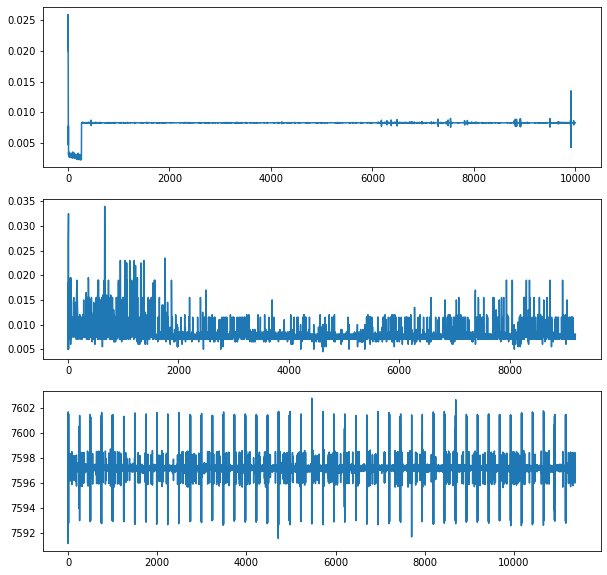

In [126]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions

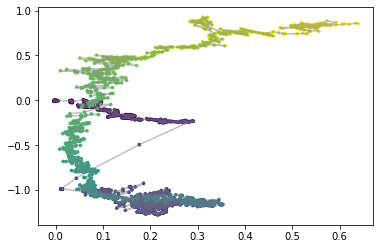

In [62]:
ballr = 45
#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

# See Seelig 2010 for reference on equations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945246/)
fta = np.cumsum(ftDf['dz'])
fty = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.cos(fta) - ballr*np.pi/180*ftDf['dx']*np.sin(fta))
ftx = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.sin(fta) + ballr*np.pi/180*ftDf['dx']*np.cos(fta))
plt.plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
plt.scatter(ftx[0:3000], fty[0:3000],s=7,c=ftDf['frame'][0:3000],cmap='viridis')

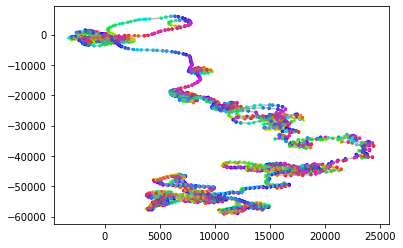

In [63]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['angle'],cmap='hsv')

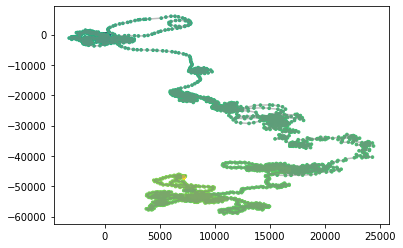

In [64]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

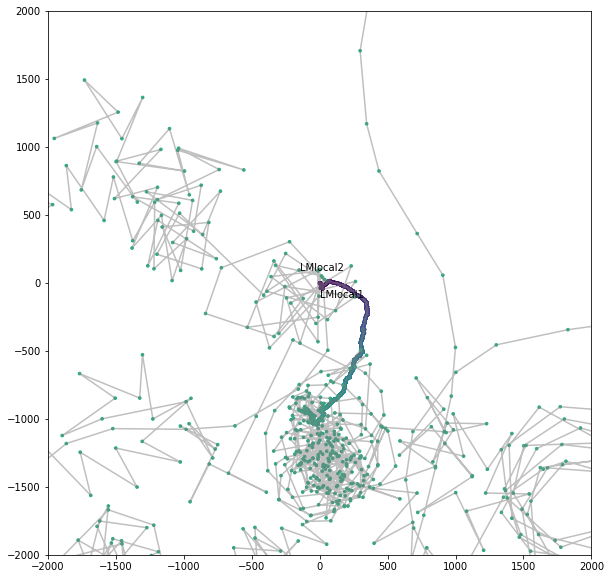

In [66]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-2000,2000], limy=[-2000,2000],myfigsize=(10,10))